# 1. Projektarbeit - Lineare Regression
© Thomas Robert Holy 2019
<br>
Version 1.0.0
<br><br>
Visit me on GitHub: https://github.com/trh0ly
<br>
Kaggle Link: https://www.kaggle.com/c/data-driven-business-analytics/leaderboard

## Grundlegene Einstellungen
### Import der Bibliotheken

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
import seaborn as sns
import sys

### Optikeinstellungen

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.width', 350)
plt.rcParams['figure.figsize'] = (12, 6) # macht die Plots größer

## Definition von Hilfsfunktionen
### Definition One-Hot-Encoding Funktion 

In [4]:
# Definition einer Funktion, die das One-Hot-Encoding durchführt
#------------
# Argumente:
# - df: DataFrame welcher bearbeitet werden soll
# - df_row: DataFrame-Spalte die bearbeitet werden soll
# - make_df: 
# ---> Wenn False, dann werden die transformierten Werte als Array zurückgegeben
# ---> Wenn True, dann wird ein DataFrame zurückgegeben
# - overwrite_inv_encoded:
# ---> Wenn None, dann werden Spaltennamen des DataFrames auf Grundlage der Merkmals-
#      ausprägungen im originalen DataFrame ermittelt
# ---> Wenn != None, dann werden die Spalten manuell überschrieben
#------------

def onehot_encoder_func(df, df_row, make_df=False, overwrite_inv_encoded=None):
    values = np.array(df[df_row]) # Transformation der DataFrame-Saplte in ein Numpy Array
    label_encoder = LabelEncoder() # Definition des Label-Encoders
    integer_encoded = label_encoder.fit_transform(values.ravel()) # Label-Encoder auf Values fitten
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') # Definition des One-Hot-Encoders
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1) # Reshape der Integer-Encoded Values
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded) # One-Hot-Encoder auf Values fitten
    """
    Wenn make_df == False:
    Rückgabe der One-Hot-Encoded 
    Values als Array
    """
    if make_df == False:
        return onehot_encoded # Rückgabe One-Hot-Endcoded Array
    """
    Wenn make_df == True:
    Rückgabe der One-Hot-Encoded 
    Values als DataFrame
    """
    if make_df == True:
        """
        Wenn overwrite_inv_encoded == None:
        Spalten des DataFrame werden nicht
        manuell überschrieben. Die Spaltennamen
        werden aus den Mermalsausprägungen des
        originalen DataFrame gewonnen.
        """
        if overwrite_inv_encoded == None:
            counter, array = 0, [] # Zähler, Main-Array werden inizialisiert
            # For-Schleife, welche ein Arrays mit Arrays generiert, welche
            # von i=0 bis i=len(onehot_encoded) jeweils eine 1 enthalten
            for i in range(0, len(onehot_encoded[0])):
                temp = [0] * len(onehot_encoded[0]) # Temporäres Array
                temp[i] = 1 # Variable i im temporären Array wird 1 gesetzt
                array.append(temp) # Generiertes Array wird dem Main-Array angefügt
            inv_encoded = onehot_encoder.inverse_transform(array) # Inverse Transformation One-Hot-Encoder
            inv_encoded = label_encoder.inverse_transform(inv_encoded.astype(int).ravel()) # Inverse Transformation Label-Encoder 
            # Generierung des DataFrames mit den One-Hot-Encoded Values und originalen Merkmalsausprägungen als Spalten-Namen
            encoded_df = pd.DataFrame(onehot_encoded, dtype=float, columns=list(inv_encoded), index=df.index)  
            return encoded_df # Rückgabe DataFrame
        """
        Wenn overwrite_inv_encoded != None:
        Spalten des DataFrame werden manuell
        überschrieben sofern Übergebene Array
        genügend Spaltennamen enthält.
        """
        if overwrite_inv_encoded != None:
            # Prüfung ob die Länge des manuell festgelegten Arrays gleich 
            # der Länge eines Arrays ist, welches aus den One-Hot-Endcoded
            # Values resultiert.
            case = len(overwrite_inv_encoded) == (len(onehot_encoded[0]))
            """
            # Sofern case = True werden die Spalten
            wie gewünscht überschrieben
            """
            if case == True:            
                # Generierung des DataFrames mit den One-Hot-Encoded Values und manuell überschriebenen Spalten-Namen
                encoded_df = pd.DataFrame(onehot_encoded, dtype=float, columns=list(overwrite_inv_encoded), index=df.index)
                return encoded_df # Rückgabe DataFrame
                """
                ERROR MESSAGE sofern "overwrite_inv_encoded"
                nicht lang genug.
                """
            else: 
                ERROR = 'ERROR Len of "overwrite_inv_encoded" have to be {}!'.format(len(onehot_encoded[0]))
                return ERROR
        """   
        ERROR MESSAGE sofern "make_df"
        kein gültiges Argument erhält.
        """
    else:
        print('ERROR: "make_df" needs an Argument!')

### Definition Funktion für ein Regressionsmodell

In [5]:
# Definition einer Funktion welche die Regression mit n erklärenden Variablen durchführt
#------------
# Argumente:
# - degrees: Anzahl erklärender Variablen
# - manuell:
# ---> Wenn False, dann Einbeziehung aller Spalten des DataFrames
# ---> Wenn True, dann wird manuelle Auswahl aktiviert
# - log: 
# ---> Wenn True, dann ausgabe der Zwischenschritte
# - plt: 
# ---> Wenn True, damm ausgabe eines Histograms für die Spalte Preis
# - submit: 
# --->Wenn True, dann werden berechnetet Werte in .csv gespeichert
#------------

def regression(n, manu_data=None, log=False, plt=False, submit=False):    
    #--------------------------------
    start = dt.datetime.now() # Startzeit ermitteln    
    #--------------------------------
    train_data = pd.read_csv('train.csv', index_col=0) # Datensatz einlesen
    train_data['Verhandlungsbasis'].fillna(0.0, inplace=True) # NaN-Werte in der Spalte "Verhandlungsbasis" füllen
    train_data['Kilometer'] / 1000.0 # Spalte "Kilometer" teilen
    #--------------------------------
    """
    Wenn log == True, dann
    Ausgabe bereinigter Dataframe
    """
    if log == True:
        print(train_data.head())
    #--------------------------------
    # One-Hot-Encoder über die Spalten 
    # "Privatverkauf", "Finanzierung" und "Hersteller" jagen 
    onehot_encoded = onehot_encoder_func(train_data, 'Privatverkauf', make_df=False)
    train_data['Privatverkauf'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(train_data, 'Finanzierung', make_df=False)
    train_data['Finanzierung'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(train_data, 'Hersteller', make_df=True)
    #--------------------------------
    # Spalte "Hersteller" aus DataFrame entfernen, da durch One-Hot-Encoder ersetzt
    # und aus One-Hot-Encoding resultierender DataFrame anfügen
    train_data = train_data.drop('Hersteller', axis=1)
    train_data = train_data.join(onehot_encoded)
    #--------------------------------
    """
    Wenn log == True, dann
    Ausgabe transformierter Dataframe
    """
    if log == True:
        print(train_data.head())
    #--------------------------------
    # (Manuelles) Modell Erstellen und fitten    
    # Erstellen einer Pipeline, die für die Prognose verwendet wird
    model = Pipeline([('add_x_square', PolynomialFeatures(degree=n)), # degree = n fügt X^n der Featurematrix hinzu
                      ('linear_regression', LinearRegression()),]) # das Regressionsmodell
    #--------------------------------
    """
    Wenn manu_data == None, dann
    fitten des Modells auf alle Spalten
    des eingelesenen DataFrames
    """
    if manu_data == None:
        model.fit(train_data.drop('Preis',axis='columns'),train_data.Preis) # fitten aller Parameter in der Pipeline
    """
    Wenn manu_data != None, dann
    fitten des Modells auf die manuell
    ausgewählten Spalten
    """
    if manu_data != None:
        case_1 = len(manu_data) <= len(train_data.columns)
        case_2 = len(manu_data) > 2
        """
        Sofern case_1 und case_2 die Bedigungen
        erfüllen, wird das Modell auf die manuell 
        ausgewählten Spalten gefittet
        """
        if case_1 == True and case_2 == True:
            X = train_data[manu_data]                                                                 
            model.fit(X.drop('Preis',axis='columns'),X.Preis) # fitten der manuell angebenen Parameter in der Pipeline 
            """
            Sofern die Bedinungen nicht 
            erfüllt werden, wird eine 
            Fehlermeldung zurückgegeben
            """
        else:
            print('ERROR Len of "manu_data" have to be 2 < len(manu_data) < {}!'.format(len(train_data.columns)))
            sys.exit
    #--------------------------------
    # Trainiertes Modell auf die Ausgangsdaten anwenden 
    """
    Sofern manu_data == None wird Prognose
    auf Baisis aller im Datensatz vorhanden 
    Spalten vorgenommen
    """
    if manu_data == None:
        pred_train = model.predict(train_data.drop('Preis',axis='columns'))
    """
    Sofern manu_data != None wird 
    Prognose auf Basis der manuell 
    ausgewählten Daten gefittet
    """
    if manu_data != None:
        pred_train = model.predict(X.drop('Preis',axis='columns'))  
    #--------------------------------
    # MSE zwischen prognostizierten Preis und tatsächlichen Preis berechnen 
    mse = mean_squared_error(train_data['Preis'], pred_train)     
    #--------------------------------
    df_test = pd.read_csv('test.csv', index_col=0) # Einlesen des Testdatensatzes
    df_test['Verhandlungsbasis'].fillna(0.0, inplace=True) # NaN-Werte in der Spalte "Verhandlungsbasis" füllen
    df_test['Kilometer'] / 1000.0 # Spalte "Kilometer" teilen
    #--------------------------------
    # One-Hot-Encoder über die Spalten 
    # "Privatverkauf", "Finanzierung" und "Hersteller" jagen 
    onehot_encoded = onehot_encoder_func(df_test, 'Privatverkauf', make_df=False)
    df_test['Privatverkauf'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(df_test, 'Finanzierung', make_df=False)
    df_test['Finanzierung'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(df_test, 'Hersteller', make_df=True)
    #--------------------------------
    # Spalte "Hersteller" aus DataFrame entfernen, da durch One-Hot-Encoder ersetzt
    # und aus One-Hot-Encoding resultierender DataFrame anfügen
    df_test = df_test.drop('Hersteller', axis=1)
    df_test = df_test.join(onehot_encoded)
    """
    Sofern manu_data != None wird
    Testdatensatz nur auf alle manuell
    ausgewählen Spalten reduziert
    """
    if manu_data != None:
        manu_data.remove('Preis')
        df_test = df_test[manu_data]
        manu_data.append('Preis')        
    #--------------------------------
    pred = model.predict(df_test) # Anwendung des Modells auf die Testdaten
    df_test['Preis'] = pred # Die Spalte "Preis" des Testdatensatzes wird mit Prognosewerden gefüllt     
    #--------------------------------
    end = dt.datetime.now() # Startzeit ermitteln  
    print('Verstrichene Zeit: {}.'.format(end - start))
    print("Mean squared error of " + str(n) + " degree model: %.2f \n" % mse)    
    #--------------------------------
    """
    Wenn log == True, dann
    Ausgabe transformierter Dataframe
    """  
    if log == True:
        print(df_test.head())
    """
    Wenn submit == True, dann
    Speicherung der prognostizierten
    Preise in eienr .csv-Datei
    """  
    if submit == True:
        df_submission = df_test['Preis'].reset_index()
        df_submission.to_csv('./submission_' + str(n) + '-degree_model.csv', index=False)
        """
        Wenn log == True, dann
        Ausgabe transformierter Dataframe
        """ 
        if log == True:
            print(df_submission.head())        
    #--------------------------------
    """
    Wenn plt == True, dann
    Ausgabe wird ein Histogramm der
    Spalte "Preis" geplottet
    """   
    if plt == True:        
        hist_train_data = df_test.hist(column=['Preis'])    
    #--------------------------------    
    return mse # Rückgabe des berechneten MSE

## Anwendung einer (multivariaten) linearen Regression
### Ausführung der Funktion "regression" in einer For-Schleife und Dokumentation der MSEs
- 0 = Einfache lineare Regression
<br>
- 1 = Regressionsmodell mit den erklärenden Variablen X, X^2
<br>
- 2 = Regressionsmodell mit den erklärenden Variablen X bis X^3
<br>
- ...
<br>
- n = Regressionsmodell mit den erklärenden Variablen X bis X^(n+1)

In [6]:
mse_liste = [] # Array welches die MSEs speichert

# For-Schleife die die Funktion "regression" n mal ausführt und
# den jeweils resultierenden MSE im Array "mse_liste" speichert
for i in range(1,8 + 1):
    mse = regression(i,log=False,submit=False)
    mse_liste.append(mse)

#--------------------------------
# Ausgabe der Berechnungen
print('Es wurden folgende MSEs berechnet:\n{}'.format(mse_liste))
print('Der kleinste MSE hat den Index {} (d.h. {} Degrees) und beträgt {}.'.format(np.argmin(mse_liste), int(np.argmin(mse_liste) + 1), min(mse_liste)))

Verstrichene Zeit: 0:00:00.116928.
Mean squared error of 1 degree model: 10159049.92 

Verstrichene Zeit: 0:00:00.030979.
Mean squared error of 2 degree model: 2644089.59 

Verstrichene Zeit: 0:00:00.069957.
Mean squared error of 3 degree model: 2050260.04 

Verstrichene Zeit: 0:00:00.177892.
Mean squared error of 4 degree model: 5431666.39 

Verstrichene Zeit: 0:00:00.533252.
Mean squared error of 5 degree model: 12023763.71 

Verstrichene Zeit: 0:00:01.464898.
Mean squared error of 6 degree model: 35448311.45 

Verstrichene Zeit: 0:00:04.759941.
Mean squared error of 7 degree model: 58631871.59 

Verstrichene Zeit: 0:00:16.705746.
Mean squared error of 8 degree model: 98140845.52 

Es wurden folgende MSEs berechnet:
[10159049.922246907, 2644089.594323958, 2050260.037667267, 5431666.39253816, 12023763.713836065, 35448311.45200197, 58631871.58542747, 98140845.52434663]
Der kleinste MSE hat den Index 2 (d.h. 3 Degrees) und beträgt 2050260.037667267.


### Run und Submit des Modells mit dem kleinsten MSE

     Hersteller  Kilometer  Zylinder  Liter  Tueren  Verhandlungsbasis Privatverkauf Finanzierung     Preis
ID                                                                                                         
165  Volkswagen    45182.4         6    3.5       4                1.0          Nein         Nein  16295.21
624  Volkswagen    40630.4         6    3.5       4                0.0            Ja         Nein  16341.80
432        Ford    37684.8         4    2.0       2                1.0            Ja         Nein  32075.98
410  Volkswagen    18635.2         6    3.8       2                0.0          Nein           Ja  18040.14
580     Renault    37374.4         6    3.6       4                0.0            Ja         Nein  19774.25
     Kilometer  Zylinder  Liter  Tueren  Verhandlungsbasis  Privatverkauf  Finanzierung     Preis  BMW  Daimler  Fiat  Ford  Renault  Volkswagen
ID                                                                                                 

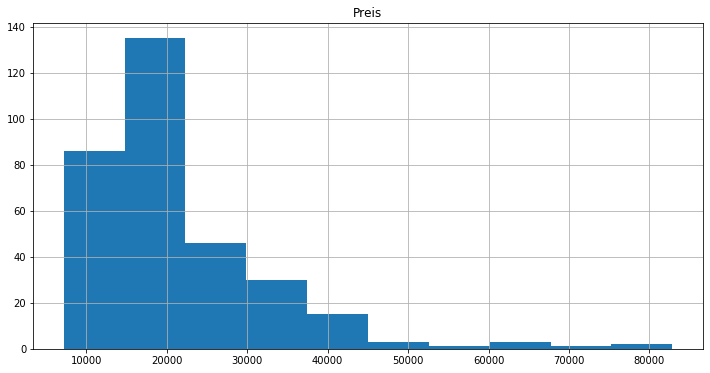

In [7]:
"""
Kaggle Score:  0.92166
"""

_ = regression(3, log=True, submit=True, plt=True)

## Weitere Überlegungen
### Heatmap zur manuellen Auswahl relevanter Features
Die Heatmap verrät welchen Einfluss die Features aus den Preis haben.
Anhand dessen kann entschieden werden welche Features verwendet werden sollten um den Preis zu prognostizieren.

(14.0, 0.0)

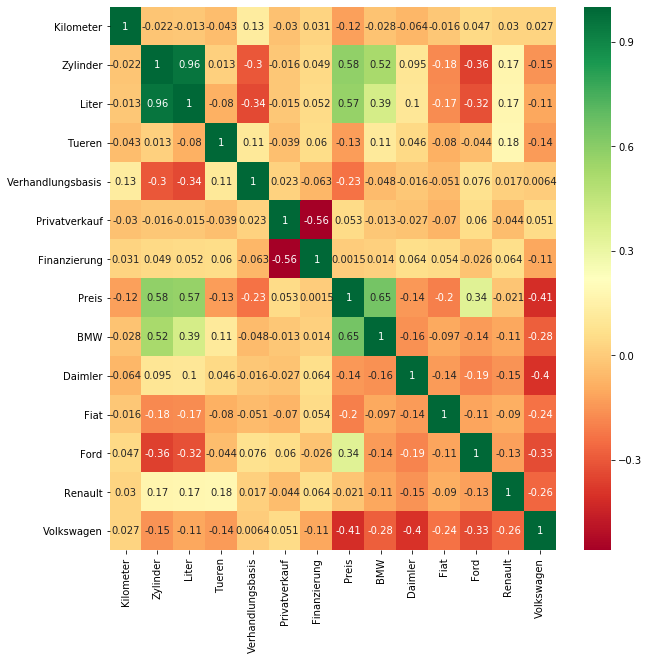

In [8]:
train_data = pd.read_csv('train.csv', index_col=0) # Datensatz einlesen
train_data['Verhandlungsbasis'].fillna(0.0, inplace=True) # NaN-Werte füllen

#--------------------------------
# Anwendung One-Hot-Encoder Funktion 
onehot_encoded = onehot_encoder_func(train_data, 'Privatverkauf', make_df=False)
train_data['Privatverkauf'] = onehot_encoded
onehot_encoded = onehot_encoder_func(train_data, 'Finanzierung', make_df=False)
train_data['Finanzierung'] = onehot_encoded
onehot_encoded = onehot_encoder_func(train_data, 'Hersteller', make_df=True)
train_data = train_data.drop('Hersteller', axis=1)
train_data = train_data.join(onehot_encoded)

#--------------------------------
# Heatmap Plotten
X = train_data.drop('Preis',axis='columns') # Independent columns
y = train_data['Preis'] # Target column
corrmat = train_data.corr() # Get correlations of each features in dataset
top_corr_features = corrmat.index
plt.figure(figsize=(10,10)) # Größe Grafik
ax = sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn") # Plot heat map
bottom, top = ax.get_ylim() # Get limits X-, Y-Achse                 
ax.set_ylim(bottom + 0.5, top - 0.5) # Erweiterterung der Limits

### Ausführung der Funktion "regression" in einer For-Schleife und Dokumentation der MSEs mit einer "manuellen" Featureauswahl

In [9]:
# Auswall relevanter Features aus Basis der Heatmap (Eigene Auswahl)
data = ['Kilometer', 'Zylinder', 'Liter', 'Tueren', 'Verhandlungsbasis',
        'BMW', 'Daimler', 'Fiat', 'Ford', 'Volkswagen', 'Preis']

mse_liste2 = [] # Array welches die MSEs speichert

# For-Schleife die die Funktion "regression" n mal ausführt und
# den jeweils resultierenden MSE im Array "mse_liste" speichert
for i in range(1,8 + 1):
    mse = regression(i, data, log=False, submit=False, plt=False)
    mse_liste2.append(mse)

#--------------------------------
# Ausgabe der Berechnungen
print('Es wurden folgende MSEs berechnet:\n{}'.format(mse_liste2))
print('Der kleinste MSE hat den Index {} (d.h. {} Degrees) und beträgt {}.'.format(np.argmin(mse_liste2), int(np.argmin(mse_liste2) + 1), min(mse_liste2)))
print('Im ersten Modell, welches nicht manuell eingeschränkt wurde, war der kleinste MSE {}.'.format(min(mse_liste)))

Verstrichene Zeit: 0:00:00.028982.
Mean squared error of 1 degree model: 10231660.49 

Verstrichene Zeit: 0:00:00.034978.
Mean squared error of 2 degree model: 2489548.20 

Verstrichene Zeit: 0:00:00.046974.
Mean squared error of 3 degree model: 2773501.12 

Verstrichene Zeit: 0:00:00.149908.
Mean squared error of 4 degree model: 8864518.71 

Verstrichene Zeit: 0:00:00.246849.
Mean squared error of 5 degree model: 11769557.30 

Verstrichene Zeit: 0:00:00.614636.
Mean squared error of 6 degree model: 37948332.47 

Verstrichene Zeit: 0:00:01.353575.
Mean squared error of 7 degree model: 28249753.78 

Verstrichene Zeit: 0:00:02.995772.
Mean squared error of 8 degree model: 40666444.71 

Es wurden folgende MSEs berechnet:
[10231660.485763377, 2489548.2035135226, 2773501.1211754447, 8864518.709236825, 11769557.303531937, 37948332.473839894, 28249753.78044307, 40666444.709369846]
Der kleinste MSE hat den Index 1 (d.h. 2 Degrees) und beträgt 2489548.2035135226.
Im ersten Modell, welches nicht

### Run und Submit des Modells mit dem festen Fit

     Hersteller  Kilometer  Zylinder  Liter  Tueren  Verhandlungsbasis Privatverkauf Finanzierung     Preis
ID                                                                                                         
165  Volkswagen    45182.4         6    3.5       4                1.0          Nein         Nein  16295.21
624  Volkswagen    40630.4         6    3.5       4                0.0            Ja         Nein  16341.80
432        Ford    37684.8         4    2.0       2                1.0            Ja         Nein  32075.98
410  Volkswagen    18635.2         6    3.8       2                0.0          Nein           Ja  18040.14
580     Renault    37374.4         6    3.6       4                0.0            Ja         Nein  19774.25
     Kilometer  Zylinder  Liter  Tueren  Verhandlungsbasis  Privatverkauf  Finanzierung     Preis  BMW  Daimler  Fiat  Ford  Renault  Volkswagen
ID                                                                                                 

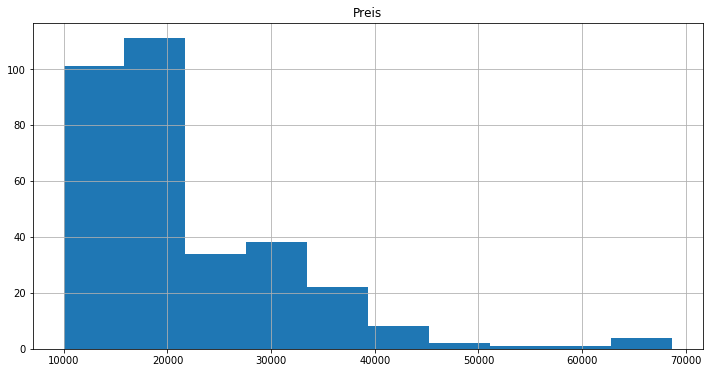

In [10]:
"""
Kaggle Score: 0.97180
- Größerer MSE als zuvor
- Besser Fit auf Testdatensatz
--> Vorheriges Modell ist Overfitted
"""

_ = regression(2, data, log=True, submit=True, plt=True)

## Lineare Lasso-Regression
### Import weiterer Pakete

In [11]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

### Definition weiterer Hilfsfunktionen
#### Funktion für das Einlesen, bereinigen und One-Hot-Encoden der Daten

In [12]:
# Definition einer Funktion, die die Daten einliest, bereinigt und One-Hot encoded
#------------
# Argumente:
# - manu_data: 
# ---> Wenn = None: Alle eingelesenen Spalten werden im DataFrame verwendet
# ---> Wenn != None: Nur eine Auswahl von Spalten wird im DataFrame verwendet
#------------

def read_and_make_data_fit(manu_data=None):
    #-------------------------------------------------------------------------
    # Trainigsdatensatz 
    train_data = pd.read_csv('train.csv', index_col=0) # Datensatz einlesen
    train_data['Verhandlungsbasis'].fillna(0.0, inplace=True) # NaN-Werte in der Spalte "Verhandlungsbasis" füllen
    train_data['Kilometer'] / 1000.0 # Spalte "Kilometer" teilen
    #--------------------------------
    # One-Hot-Encoding
    onehot_encoded = onehot_encoder_func(train_data, 'Privatverkauf', make_df=False)
    train_data['Privatverkauf'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(train_data, 'Finanzierung', make_df=False)
    train_data['Finanzierung'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(train_data, 'Hersteller', make_df=True)
    #--------------------------------
    # DataFrames joinen
    train_data = train_data.drop('Hersteller', axis=1)
    train_data = train_data.join(onehot_encoded)
    #--------------------------------
    # Ggf. auswahl der Spalten
    if manu_data != None:
        train_data = train_data.filter(manu_data, axis=1)
        
    #-------------------------------------------------------------------------
    # Testdatensatz
    df_test = pd.read_csv('test.csv', index_col=0) # Einlesen des Testdatensatzes
    df_test['Verhandlungsbasis'].fillna(0.0, inplace=True) # NaN-Werte in der Spalte "Verhandlungsbasis" füllen
    df_test['Kilometer'] / 1000.0 # Spalte "Kilometer" teilen
    #--------------------------------
    # One-Hot-Encoding
    onehot_encoded = onehot_encoder_func(df_test, 'Privatverkauf', make_df=False)
    df_test['Privatverkauf'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(df_test, 'Finanzierung', make_df=False)
    df_test['Finanzierung'] = onehot_encoded
    onehot_encoded = onehot_encoder_func(df_test, 'Hersteller', make_df=True)
    #--------------------------------
    # DataFrames joinen
    df_test = df_test.drop('Hersteller', axis=1)
    df_test = df_test.join(onehot_encoded)
    #--------------------------------
    # Ggf. auswahl der Spalten
    if manu_data != None:
        df_test = df_test.filter(manu_data, axis=1)
        
    return train_data, df_test

#### Funktion zur Erstellung des Modells

In [13]:
# Definition einer Funktion, die eine Gittersuche durchführt und den besten Hyperparamtet alpha (=lambda) zurückgibt
#------------
# Argumente:
# - alpha_space: Übergabe einer Range mit alpha-Paramtern an die Funktion
# - degrees: Grad zur Bestmimmung der Modellkomplexität
# - cvs: Komplexität der Kreuzvalidierung
# - threads: Anzahl der paralell ausgeführten Berechnungen
# - manu_data: 
# ---> Wenn = None: Alle eingelesenen Spalten werden im DataFrame verwendet
# ---> Wenn != None: Nur eine Auswahl von Spalten wird im DataFrame verwendet
# - log: 
# ---> Wenn True, dann ausgabe der Zwischenschritte
# - plt: 
# ---> Wenn True, damm ausgabe eines Histograms für die Spalte Preis
# - submit: 
# --->Wenn True, dann werden berechnetet Werte in .csv gespeichert
#------------

def lasso_model_grid_search(alpha_space, degrees=2, cvs=5, threads=8, manu_data=None, submit=False, plt=False, log=False):
    start = dt.datetime.now() # Startzeit ermitteln  
    #--------------------------------
    # Daten einlesen
    trainData, testData = read_and_make_data_fit(manu_data)    
    #--------------------------------
    # Pipeline erzeugen
    lasso_pipe_loop = Pipeline([
          ('add_x_square', PolynomialFeatures(degree=degrees,include_bias=False)),  # degree = 2 fügt X^2 der Featurematrix hinz
          ('scaler', preprocessing.StandardScaler()), 
          ('lasso_regression', linear_model.Lasso(fit_intercept=True, max_iter = 100000))])  # das Regressionsmodell
    #--------------------------------
    # Lambda- / Alpha-Kette definieren
    lasso_pipe_parameter = [
        {'lasso_regression__alpha': alpha_space}]
    #--------------------------------
    # Gittersuche
    grid_search_lasso = GridSearchCV(
        estimator=lasso_pipe_loop, 
        param_grid=lasso_pipe_parameter,
        scoring='neg_mean_squared_error',
        cv=cvs,
        n_jobs=threads,
        iid=False)
    #--------------------------------
    # Fitten auf Trainigsdatensatz
    _ = grid_search_lasso.fit(trainData.drop('Preis',axis='columns'),trainData.Preis)
    #--------------------------------
    # Anwendung des Modells auf Testdatensatz und Submit
    pred = grid_search_lasso.predict(testData)
    testData['Preis'] = pred
    df_submission = testData['Preis'].reset_index()
    end = dt.datetime.now() # Startzeit ermitteln  
    print('Verstrichene Zeit: {}.'.format(end - start))
    #--------------------------------
    if submit == True:
        df_submission.to_csv('./submission_lambda_' + str(degrees) + '-degrees.csv', index=False)
    #--------------------------------
    # Ausgabe bester Hyperparamter und plotten    
    print("Bester Hyperparameter lambda: {} ".format(grid_search_lasso.best_params_['lasso_regression__alpha'] ))
    print("MSE für besten Hyperparameter: {} \n".format(grid_search_lasso.best_score_))
    if log == True:
        print(df_submission.head())
    #--------------------------------
    if plt == True:
        #_ = pd.DataFrame(grid_search_lasso.cv_results_)[['rank_test_score']].plot()
        hist_train_data = testData.hist(column=['Preis'])
        
    return grid_search_lasso.best_score_

### Ausführung der Funktion "lasso_model_grid_search" in einer For-Schleife und Dokumentation der MSEs

In [14]:
alpha_range = np.logspace(start=0, stop=10, num=1000)
cvsss = 5

data = ['Kilometer', 'Zylinder', 'Liter', 'Tueren', 'Verhandlungsbasis',
        'BMW', 'Daimler', 'Fiat', 'Ford', 'Volkswagen', 'Preis']

lasso_mse_liste = []
for i in range(1,3 + 1):
    mse = lasso_model_grid_search(alpha_space=alpha_range, degrees=i, cvs=cvsss, threads=10, manu_data=data, submit=False, plt=False, log=False)
    lasso_mse_liste.append(mse)

#--------------------------------
# Ausgabe der Berechnungen
print('Es wurden folgende MSEs berechnet:\n{}'.format(lasso_mse_liste))
print('Der kleinste MSE hat den Index {} (d.h. {} Degrees) und beträgt {}.'.format(np.argmax(lasso_mse_liste), int(np.argmax(lasso_mse_liste) + 1), max(lasso_mse_liste)))

Verstrichene Zeit: 0:00:08.046359.
Bester Hyperparameter lambda: 23.516428844943487 
MSE für besten Hyperparameter: -11099138.030149676 

Verstrichene Zeit: 0:00:15.173267.
Bester Hyperparameter lambda: 3.6354699612933197 
MSE für besten Hyperparameter: -3321251.3147764006 

Verstrichene Zeit: 0:01:33.304198.
Bester Hyperparameter lambda: 1.4459729217920199 
MSE für besten Hyperparameter: -3434381.2617137632 

Es wurden folgende MSEs berechnet:
[-11099138.030149676, -3321251.3147764006, -3434381.2617137632]
Der kleinste MSE hat den Index 1 (d.h. 2 Degrees) und beträgt -3321251.3147764006.


### Run und Submit des Modells mit dem festen Fit

Verstrichene Zeit: 0:00:15.589489.
Bester Hyperparameter lambda: 3.6354699612933197 
MSE für besten Hyperparameter: -3321251.3147764006 

    ID         Preis
0  536  19034.894009
1  338  13896.295480
2  211  30989.602794
3  298  13373.881920
4  124  31140.300711


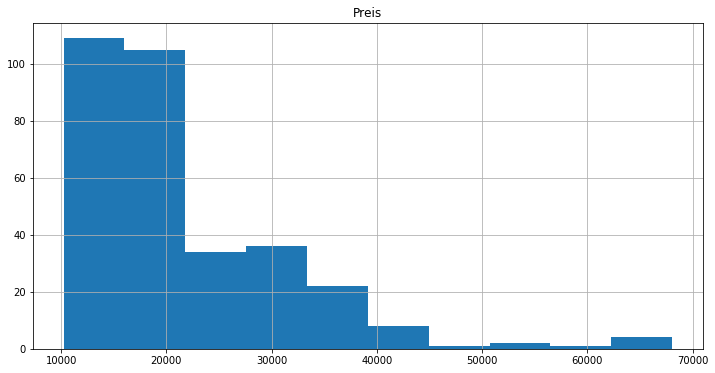

In [15]:
"""
Kaggle Score: 0.97154
-> Sehr nah am Top-Score von 0.97180
"""

_ = lasso_model_grid_search(alpha_space=alpha_range, degrees=2, cvs=cvsss, threads=10, manu_data=data, submit=True, plt=True, log=True)